# Short Term Water Demand Forecasting with Statistical and AI Methods

### Oscar Wooding
Department of Civil and Environmental Engineering, Imperial College London

### Initial Statistical Analysis


In [1]:
# imports 
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
import matplotlib_inline
import datetime as dt
import warnings
from scipy import stats
import math
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from scipy.stats import norm

from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import MSTL

# imports for time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# box-cox transformation for skeewed data
from scipy.stats import boxcox, norm
from scipy.special import inv_boxcox

%matplotlib inline

pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)

# improve matlab output
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

rc('text', usetex=False)
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=11)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# adjust the format of the data set
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

warnings.filterwarnings("ignore")


### *Load*

In [2]:
# load inflow data
inflow_data = pd.read_csv("../data/InflowDataImputed.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

inflow_data = inflow_data.set_index('date_time')

# change index format to datetime
inflow_data.index = pd.to_datetime(inflow_data.index)

dmas = list(inflow_data.columns)

# # print first two rows
inflow_data.head(3)


dma_a  dma_b  dma_c  dma_d  dma_e  dma_f  dma_g  dma_h  \
date_time                                                                     
2021-01-01 00:00:00   5.58   8.02   3.70  25.61  60.72   6.67  18.91  13.86   
2021-01-01 01:00:00   5.19   7.65   3.56  24.07  56.11   6.49  16.60  12.42   
2021-01-01 02:00:00   7.27   7.65   3.27  23.86  53.80   6.21  15.43  10.95   

                     dma_i  dma_j  
date_time                          
2021-01-01 00:00:00  17.68  21.55  
2021-01-01 01:00:00  17.25  20.78  
2021-01-01 02:00:00  16.84  20.45

In [3]:
# load weather data
weather_data = pd.read_csv("../data/WeatherDataImputed.csv")

weather_data = weather_data.set_index('date_time')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index)

# make list of special days for the DMAs region
official_holidays = ["2021-01-01","2021-01-06","2021-04-04","2021-04-05","2021-04-25","2021-05-01","2021-06-02","2021-08-15","2021-11-01","2021-12-05","2021-12-25","2021-12-26","2022-01-01","2022-01-06","2022-04-17","2022-04-18","2022-04-25","2022-05-01","2022-06-22","2022-08-15","2022-11-01","2022-12-08","2022-12-25","2022-12-26"]

legally_not_recongnized_holidays = ["2021-04-23","2021-05-23","2022-04-23","2022-06-05"]

event_day = ["2021-03-28","2021-05-09","2021-10-31","2021-11-28","2021-05-12","2021-12-12","2021-12-19","2021-12-31","2022-03-27","2022-04-10","2022-05-08","2022-05-09","2022-10-30","2022-11-27","2022-12-04","2022-12-11","2022-12-18","2022-12-31"]

# make columns for special days
weather_data['official_holiday'] = 0
weather_data['legally_not_recongnized_holidays'] = 0
weather_data['event_day'] = 0
weather_data['weekend'] = 0

# add indicator variable for speciall days
for i in weather_data.index:
    if str(i)[:10] in official_holidays:
        weather_data['official_holiday'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in legally_not_recongnized_holidays:
        weather_data['legally_not_recongnized_holidays'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in event_day:
        weather_data['event_day'][i] = 0

# add variable for weekend days
for i in weather_data.index:
    if i.weekday() == 5 or i.weekday() == 6:
        weather_data['weekend'][i] = 1
        
weather_data.head(5)

rain_depth  air_temp  air_humid  windspeed  \
date_time                                                         
2021-01-01 00:00:00        0.00      7.20      79.00       9.00   
2021-01-01 01:00:00        0.00      7.30      79.00       6.00   
2021-01-01 02:00:00        0.00      7.60      78.00       4.00   
2021-01-01 03:00:00        0.00      8.20      75.00       4.00   
2021-01-01 04:00:00        0.00      7.70      77.00       7.00   

                     official_holiday  legally_not_recongnized_holidays  \
date_time                                                                 
2021-01-01 00:00:00                 1                                 0   
2021-01-01 01:00:00                 1                                 0   
2021-01-01 02:00:00                 1                                 0   
2021-01-01 03:00:00                 1                                 0   
2021-01-01 04:00:00                 1                                 0   

                     event_day  weekend  
date_time                                
2021-01-01 00:00:00          0        0  
2021-01-01 01:00:00          0        0  
2021-01-01 02:00:00          0        0  
2021-01-01 03:00:00          0        0  
2021-01-01 04:00:00          0        0

### Statistical Models

#### 1. Data Preparation

In [4]:
# remove dupes
inflow_data = inflow_data[~inflow_data.index.duplicated(keep='first')]
weather_data = weather_data[~weather_data.index.duplicated(keep='first')]


#### 1.1 Transforms

In [5]:
# find best boxcox transformation. Include datetime index if given
def boxcox_transform(df,lmda=None,alpha=None,optimizer=None):
    transform_df = df.copy()
    
    for col in df.columns:
        x = df[col]
        index = df.index
        
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)

        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)

        transform_df[col] = boxcox_data
        
    return transform_df

        
# reverse transformation. Include datetime index if given
def inv_boxcox_tranform(x, lmda, out=None):

    transform_df = df.copy()
    
    for col in df.columns:
        x = df[col]
        index = df.index
        
        if lmda == None:
            boxcox_data, lmda = inv_boxcox(x, lmbda=None, out=None)

        else:
            boxcox_data = inv_boxcox(x, lmbda=lmda, out=None)
        
        transform_df[col] = boxcox_data
        
    return transform_df
    

    
# min max transformation
def normalise(df): 
    
    norm_df = df.copy()
    
    for col in df.columns: 
        values = df[col].values
        values = values.reshape((len(values), 1))

        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler = scaler.fit(values)
        
        normalised = scaler.transform(values)
        
        norm_df[col] = normalised
    
    return norm_df
     
    
# standardise transformation
def standardise(df): 
    
    stand_df = df.copy()
    
    for col in df.columns: 
        values = df[col].values
        values = values.reshape((len(values), 1))

        scaler = StandardScaler()
        scaler = scaler.fit(values)
        
        standardised = scaler.transform(values)
        
        stand_df[col] = standardised
    
    return stand_df
        

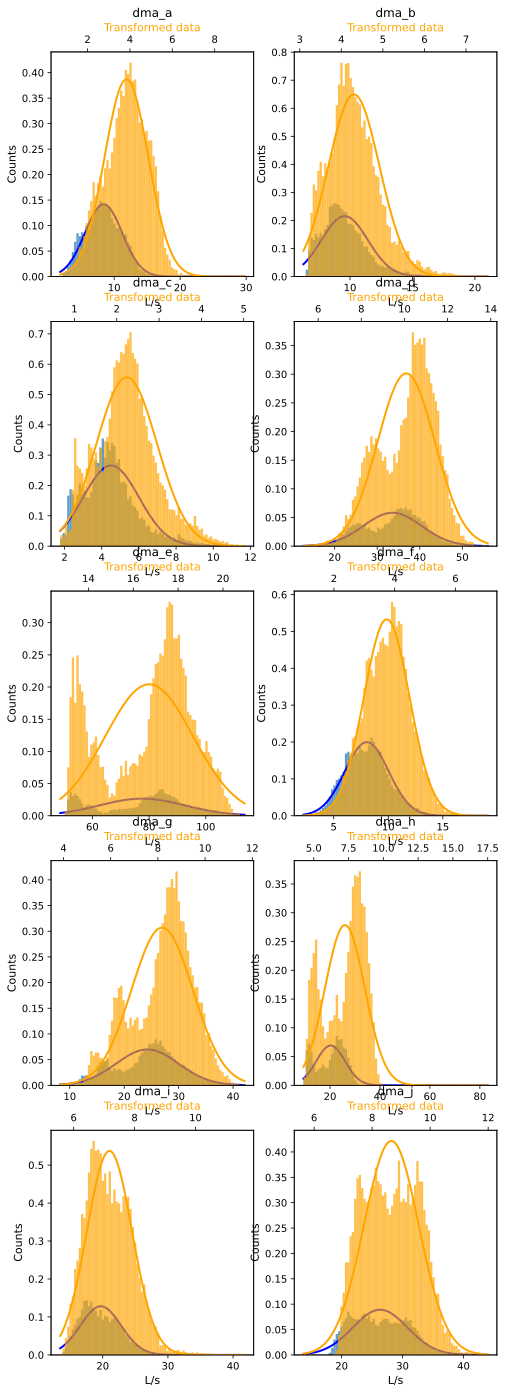

In [6]:
# box cox transform
bc_inflow_data = boxcox_transform(inflow_data[dmas])

# comparison of initial data and transform
fig, axs = plt.subplots(5, 2, figsize=(8,24))
axs = axs.flatten()

for i, dma in enumerate(dmas): 
    
    # compare distributions of original and transformed data
    ax2 = axs[i].twiny()
    axs[i].set_title(dma)
    axs[i].hist(inflow_data[dma].values, density=True,bins=80,alpha=0.7)
    ax2.hist(bc_inflow_data[dma].values, density=True,bins=80, color='orange', alpha=0.7)
    
    # fit norm to original data
    # mean and standard deviation
    mu, std = norm.fit(inflow_data[dma].dropna(axis=0)) 
    
    # Plot the PDF
    xmin, xmax = inflow_data[dma].min(), inflow_data[dma].max()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    axs[i].plot(x, p, 'blue', linewidth=2)
    
    # fit norm to transformed data
    # mean and standard deviation
    mu, std = norm.fit(bc_inflow_data[dma].dropna(axis=0)) 
    
    # Plot the PDF
    xmin, xmax = bc_inflow_data[dma].min(), bc_inflow_data[dma].max()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    ax2.plot(x, p, 'orange', linewidth=2)
    
    axs[i].set_ylabel('Counts')
    axs[i].set_xlabel("L/s")
    ax2.set_xlabel("Transformed data", color='orange')

plt.show()
    

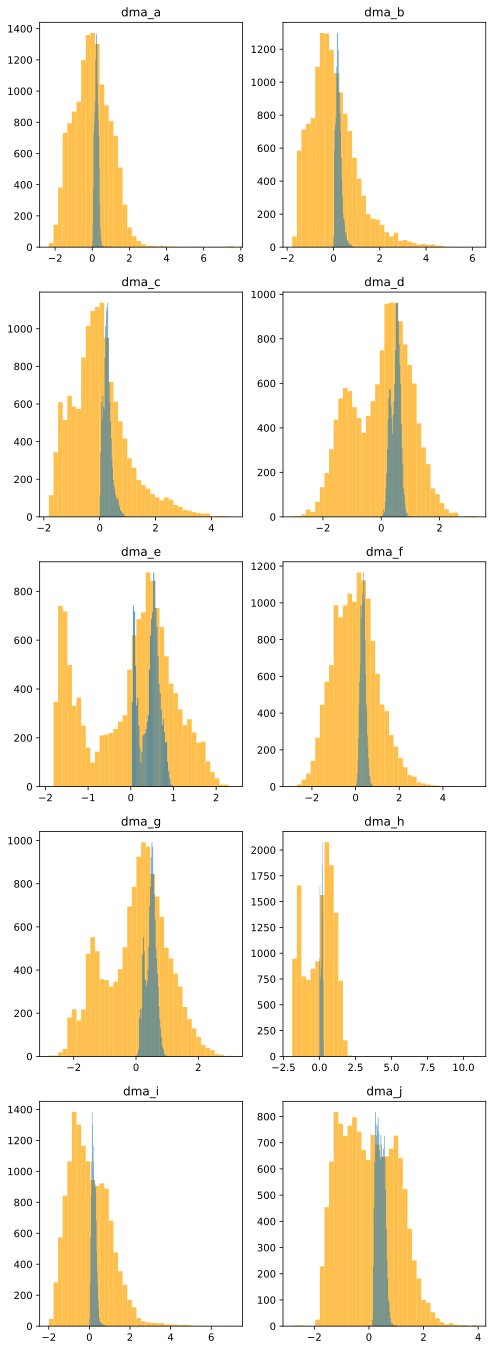

In [7]:
# box cox transform
norm_inflow_data = normalise(inflow_data[dmas])
std_inflow_data = standardise(inflow_data[dmas])

# comparison of initial data and transform
fig, axs = plt.subplots(5, 2, figsize=(8,24))
axs = axs.flatten()

for i, dma in enumerate(dmas): 
    
    # compare distributions of original and transformed data
    axs[i].set_title(dma)
    axs[i].hist(std_inflow_data[dma].values, density=False,bins=40, color='orange', alpha=0.7)
    axs[i].hist(norm_inflow_data[dma].values, density=False,bins=40,alpha=0.7)
    
    """
    # fit norm to original data
    # mean and standard deviation
    mu, std = norm.fit(norm_inflow_data[dma].dropna(axis=0)) 
    
    # Plot the PDF
    xmin, xmax = norm_inflow_data[dma].min(), norm_inflow_data[dma].max()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    axs[i].plot(x, p, 'blue', linewidth=2)
    
    # fit norm to transformed data
    # mean and standard deviation
    mu, std = norm.fit(std_inflow_data[dma].dropna(axis=0)) 
    
    # Plot the PDF
    xmin, xmax = std_inflow_data[dma].min(), std_inflow_data[dma].max()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    ax2.plot(x, p, 'orange', linewidth=2)
    
    axs[i].set_ylabel('Counts')
    axs[i].set_xlabel("L/s")
    ax2.set_xlabel("Transformed data", color='orange')
    """

plt.show()


#### 1.2 Splitting data

In [27]:
# splitting data
train_start_dt = "2022-04-01 00:00:00"
inflow_df = inflow_data[(inflow_data.index >= train_start_dt)].copy()
weather_df = weather_data[(weather_data.index >= train_start_dt)].copy()

# percentage of data for each split
train_pc = 0.8
no_train = len(inflow_df) - 168 #int(train_pc * len(inflow_df))
test_pc = 0.2
no_test = 168 #int(test_pc * len(inflow_df))

train = inflow_df.iloc[0:no_train, :][dmas].copy()
test = inflow_df.iloc[no_train:no_train+no_test, :][dmas].copy()

train_exog = weather_df.iloc[0:no_train, :].copy()
test_exog = weather_df.iloc[no_train:no_train+no_test, :].copy()

print("Training data shape: ", train.shape)
print("Test data shape: ", test.shape)


Training data shape:  (2592, 10)
Test data shape:  (168, 10)


#### 3. Averageing model

#### *3.1 Methods*

In [9]:
# FUNCTIONS
# Mean Day Impute
def MeanDayImpute(df, dma, lag=3, memory=0.4, res_window=10, p=0.95): 
    """
    Fills missing data values with the average for that day 
    calcuated as an exponential average of the past (lag)
    occurances for that time and day.
    
    df - total dataframe of all dma
    dma - dma of interest
    lag - number of past values averaged
    memory - importance of recent values
    res_window - window used to average rolling residual
    
    """
    
    # exponential mean component
    avg_df = df[[dma]].copy() 
    #avg_df = avg_df[-(lag+1)*168:]
    avg_df['mean'] = 0
    avg_df['std_dev'] = 0
    
    for delta in np.arange(lag, 0, -1):
        avg_df[dma+str(delta)] = avg_df[dma].shift(24*7*delta)
        
        if delta == lag: 
            avg_df['mean'] = avg_df[dma+str(delta)]
        else:
            avg_df['mean'] = avg_df['mean']*(1-memory) + avg_df[dma+str(delta)]*memory
        
    # finding std of each day and hour for confidence bands (assuming norm)
    avg_df['day'] = avg_df.index.weekday
    avg_df['hour'] = avg_df.index.hour
    avg_vals = avg_df.groupby(by=['day', 'hour']).mean()[dma]
    
    std_vals = avg_df.groupby(by=['day', 'hour'])[[dma]].std()
    avg_df['std'] = [std_vals.loc[(x['day'],x['hour'])][0] for _,x in avg_df.iterrows()]
    
    # residual correction component
    avg_df['residual'] = avg_df[dma] - avg_df['mean']
    avg_df['res_correction'] = avg_df['residual'].rolling(window=res_window, min_periods=1, win_type='exponential').mean()
    avg_df['mean'] = avg_df['mean'] + avg_df['res_correction'].fillna(0)
    
    for idx in avg_df[avg_df['mean'].isna()].index: 
        avg_df.loc[idx, 'mean'] = avg_vals.loc[idx.weekday, idx.hour]
    
    # set confidence bounds
    for i in avg_df.index: 
        ci = norm.interval(p, loc=avg_df.loc[i, 'mean'], scale=avg_df.loc[i, 'std'])
        avg_df.loc[i, 'upper_conf'] = ci[1]
        avg_df.loc[i, 'lower_conf'] = ci[0]
    
    return avg_df['mean'], avg_df['upper_conf'], avg_df['lower_conf']


# Correlation Partners
def CorrPartner(data, thresh=0.7, period=12):
    """
    Finds dmas which have a correlation over the threshold
    across the specified period in weeks
    
    thresh - correlation threshold for partner to be considered
    period - number of weeks to consider correlation over
    
    """
    # Find comparison partner
    df = data.copy()
    correlation = df[df.index[-1]-dt.timedelta(weeks=period)::].corr()
    correlation = correlation[correlation!=1]
    partners = {
        dma: list(correlation[(correlation[dma]>=thresh)].index) 
        for dma in correlation.columns
    }
    
    return partners

def KmeanImpute(df, dma, partners, k=3): 
    """
    Imputes data using k means alogrithm for correlated dmas
    
    df - dataframe to impute
    k - number of neighbours
    dma - dma to impute
    
    """
    # Initialize the KNN imputer with k=5
    imputer = KNNImputer(n_neighbors=k)
    cols = partners[dma]+[dma]  # correlated partner set
    
    return imputer.fit_transform(df[cols])

#### *3.2 Run*

Forecasting horizon: 168 hours
Running for dma_a...


NameError: name 'results' is not defined

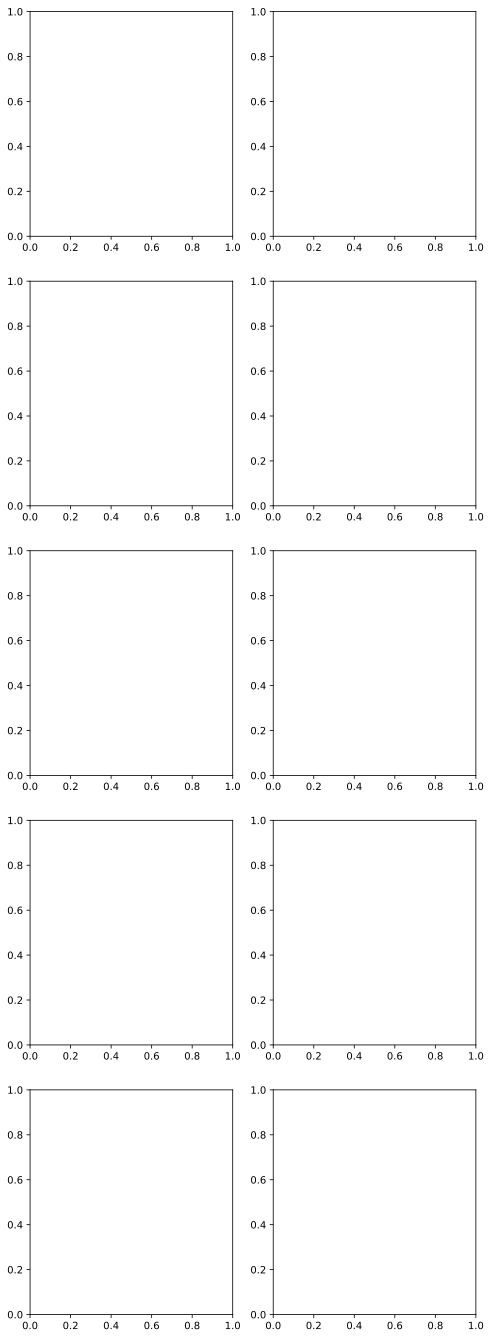

In [10]:
HORIZON = no_test
print("Forecasting horizon:", HORIZON, "hours")

results_a = test.copy()
ci_lower = test.copy()
ci_upper = test.copy()

# iterate over dmas
for dma in ['dma_a']: 
    print(f"Running for {dma}...")
    result_dma = train.copy()
    # forecast 1 step at a time
    for i in np.arange(HORIZON): 
        forecast, upper, lower = MeanDayImpute(
            result_dma, 
            dma, 
            lag=6, 
            memory=0.4, 
            res_window=10
        )
    
        result_dma = pd.concat([result_dma, test.iloc[[i]]], axis=0)
        result_dma[dma].iloc[-1] = forecast[-1]

    upper = upper
    lower = lower

    ci_lower[dma] = lower
    ci_upper[dma] = upper
    
    results_a[dma] = result_dma[dma]

# comparison of initial data and transform
fig, axs = plt.subplots(5, 2, figsize=(8,24))
axs = axs.flatten()

for i, dma in enumerate(results.columns): 
    axs[i].plot(test[dma], 'orange', linewidth=2, label='forecast')
    axs[i].plot(results[dma], 'blue', linewidth=2, label='observed')
    axs[i].fill_between(results_a.index, ci_lower[dma], ci_upper[dma] ,color='green',alpha=0.2)
    
    axs[i].set_ylabel('demand')
    axs[i].set_xlabel('date')
    leg = axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
        fancybox=False, shadow=False, ncol=6, edgecolor='w', borderpad=0.5)
    leg.get_frame().set_linewidth(0.5)
    
plt.show()


#### *3.3 Metrics*

In [11]:
# metrics
from utils import metrics

mape = {dma: metrics.mape(results_a[dma], test[dma]) for dma in dmas}
mape['total'] = sum(mape.values())
rmse = {dma: metrics.rmse(results_a[dma], test[dma]) for dma in dmas}
rmse['total'] = sum(rmse.values())
mae = {dma: metrics.mae(results_a[dma], test[dma]) for dma in dmas}
mae['total'] = sum(mae.values())

print(mape)

{'dma_a': 0.13495086280988525, 'dma_b': 0.0, 'dma_c': 0.0, 'dma_d': 0.0, 'dma_e': 0.0, 'dma_f': 0.0, 'dma_g': 0.0, 'dma_h': 0.0, 'dma_i': 0.0, 'dma_j': 0.0, 'total': 0.13495086280988525}


#### 4. Naive forecasting

#### *4.1 Run*

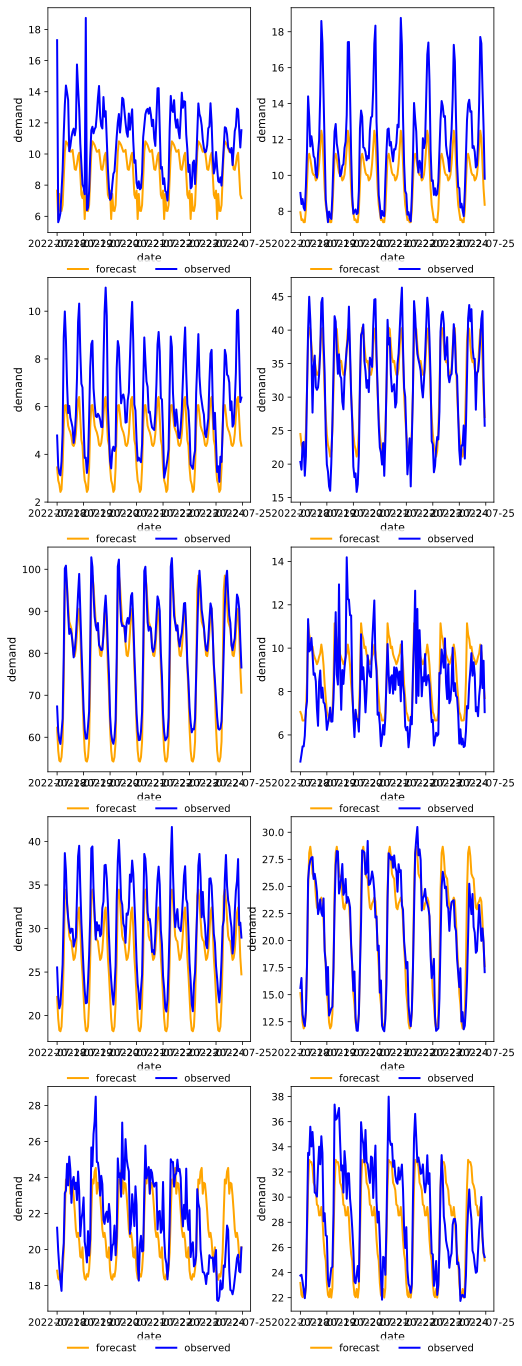

In [12]:
# imports
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster

# make empty datafram to store results
results_b = test.copy()

# setup plot
# comparison of initial data and transform
fig, axs = plt.subplots(5, 2, figsize=(8,24))
axs = axs.flatten()

# select dma for analysis
for i, dma in enumerate(inflow_data.columns):

    y_train = train[dma].copy()
    y_test = test[dma].copy()

    #Naive Forecaster
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster = NaiveForecaster(strategy = 'mean', sp=24)
    forecaster.fit(y_train)
    # results of naive forecaster
    y_pred_naive = forecaster.predict(fh)
    results_b[dma] = y_pred_naive

    axs[i].plot(y_pred_naive, color='orange', label='forecast', linewidth=2)
    axs[i].plot(y_test, color='blue', label='observed', linewidth=2)

    axs[i].set_ylabel('demand')
    axs[i].set_xlabel('date')
    leg = axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
        fancybox=False, shadow=False, ncol=6, edgecolor='w', borderpad=0.5)
    leg.get_frame().set_linewidth(0.5)
    
plt.show()
    

#### *4.2 Metrics*

In [13]:
# print metrics
mape = {dma: metrics.mape(results_b[dma], test[dma]) for dma in dmas}
mape['total'] = sum(mape.values())
rmse = {dma: metrics.rmse(results_b[dma], test[dma]) for dma in dmas}
rmse['total'] = sum(rmse.values())
mae = {dma: metrics.mae(results_b[dma], test[dma]) for dma in dmas}
mae['total'] = sum(mae.values())

print(mape)

{'dma_a': 0.18071898195150915, 'dma_b': 0.13846427967263364, 'dma_c': 0.22878729972360837, 'dma_d': 0.08804348543698949, 'dma_e': 0.04844455708044871, 'dma_f': 0.1460816190498336, 'dma_g': 0.11605166513696163, 'dma_h': 0.068233108859023, 'dma_i': 0.08310432733458792, 'dma_j': 0.07763277888189787, 'total': 1.1755621031274932}


#### 5. AutoRegressive Model

#### *5.1 Run*

Running for dma_a...


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.97805D+00    |proj g|=  1.69284D-01

At iterate    5    f=  1.85536D+00    |proj g|=  1.82200D-02

At iterate   10    f=  1.84273D+00    |proj g|=  6.63654D-03

At iterate   15    f=  1.83691D+00    |proj g|=  5.84766D-02

At iterate   20    f=  1.83276D+00    |proj g|=  4.54188D-03

At iterate   25    f=  1.83126D+00    |proj g|=  3.11207D-03

At iterate   30    f=  1.83095D+00    |proj g|=  2.43529D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

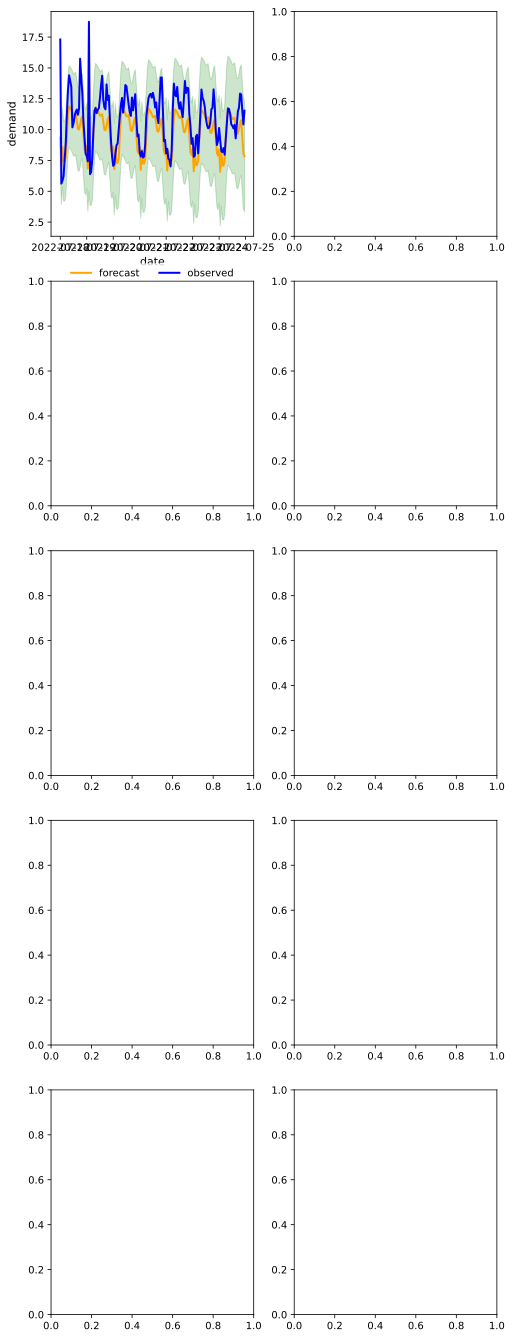

In [15]:
# imports
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# make empty datafram to store results
results_c = test.copy()
ci_lower = test.copy()
ci_upper = test.copy()
residuals_train = pd.DataFrame()
residuals_test = pd.DataFrame()

# setup plot
# comparison of initial data and transform
fig, axs = plt.subplots(5, 2, figsize=(8,24))
axs = axs.flatten()

# select dma for analysis
for i, dma in enumerate(['dma_a']):
    print(f"Running for {dma}...")
    
    y_train = train[dma].copy()
    y_test = test[dma].copy()

    # implement sarimaX model    
    # the statsmodel package applies the difference already if needed.
    model = SARIMAX(y_train, order=(2,0,2), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
    model_fit = model.fit()
    y_pred = model_fit.get_forecast(len(y_test)).summary_frame(alpha=0.05)

    results_c[dma] = y_pred['mean']
    ci_lower[dma] = y_pred['mean_ci_lower']
    ci_upper[dma] = y_pred['mean_ci_upper']
    residuals_train[dma] = model_fit.resid
    residuals_test[dma] = test[dma] - y_pred['mean']

    # plot results
    axs[i].plot(results_c[dma], color='orange', label='forecast', linewidth=2)
    axs[i].plot(y_test, color='blue', label='observed', linewidth=2)
    axs[i].fill_between(results_c.index, ci_lower[dma], ci_upper[dma] ,color='green',alpha=0.2)

    axs[i].set_ylabel('demand')
    axs[i].set_xlabel('date')
    leg = axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
        fancybox=False, shadow=False, ncol=6, edgecolor='w', borderpad=0.5)
    leg.get_frame().set_linewidth(0.5)
    
    

plt.show()

#### *5.2 Metrics*

In [97]:
# print metrics
mape = {dma: metrics.mape(results_c[dma], test[dma]) for dma in dmas}
mape['total'] = sum(mape.values())
rmse = {dma: metrics.rmse(results_c[dma], test[dma]) for dma in dmas}
rmse['total'] = sum(rmse.values())
mae = {dma: metrics.mae(results_c[dma], test[dma]) for dma in dmas}
mae['total'] = sum(mae.values())

print(mape)


{'dma_a': 0.12045043329999595, 'dma_b': 0.0, 'dma_c': 0.0, 'dma_d': 0.0, 'dma_e': 0.0, 'dma_f': 0.0, 'dma_g': 0.0, 'dma_h': 0.0, 'dma_i': 0.0, 'dma_j': 0.0, 'total': 0.12045043329999595}


### Result Analysis

In [99]:
# imports

# get residuals from SARIMAX
train_exog['dma_a_residual'] = residuals_train
train_exog['dma_a'] = train['dma_a']
train_exog['day'] = train_exog.index.weekday
train_exog['hour'] = train_exog.index.hour

# get correlations
train_exog.corr()


rain_depth  air_temp  air_humid  windspeed  \
rain_depth                              1.00     -0.04       0.09       0.06   
air_temp                               -0.04      1.00      -0.23      -0.06   
air_humid                               0.09     -0.23       1.00      -0.29   
windspeed                               0.06     -0.06      -0.29       1.00   
official_holiday                        0.01     -0.16      -0.07       0.10   
legally_not_recongnized_holidays       -0.01     -0.04       0.18      -0.08   
event_day                                NaN       NaN        NaN        NaN   
weekend                                -0.02     -0.01      -0.09       0.20   
dma_a_residual                         -0.02     -0.04       0.04      -0.05   
dma_a                                  -0.05      0.58      -0.07      -0.05   
day                                    -0.00      0.00      -0.03       0.15   
hour                                    0.01      0.13       0.01      -0.01   
extra                                  -0.03     -0.01       0.04      -0.04   

                                  official_holiday  \
rain_depth                                    0.01   
air_temp                                     -0.16   
air_humid                                    -0.07   
windspeed                                     0.10   
official_holiday                              1.00   
legally_not_recongnized_holidays             -0.03   
event_day                                      NaN   
weekend                                       0.05   
dma_a_residual                               -0.01   
dma_a                                        -0.12   
day                                          -0.03   
hour                                         -0.00   
extra                                        -0.00   

                                  legally_not_recongnized_holidays  event_day  \
rain_depth                                                   -0.01        NaN   
air_temp                                                     -0.04        NaN   
air_humid                                                     0.18        NaN   
windspeed                                                    -0.08        NaN   
official_holiday                                             -0.03        NaN   
legally_not_recongnized_holidays                              1.00        NaN   
event_day                                                      NaN        NaN   
weekend                                                       0.21        NaN   
dma_a_residual                                               -0.02        NaN   
dma_a                                                        -0.08        NaN   
day                                                           0.17        NaN   
hour                                                          0.00        NaN   
extra                                                        -0.01        NaN   

                                  weekend  dma_a_residual  dma_a   day  hour  \
rain_depth                          -0.02           -0.02  -0.05 -0.00  0.01   
air_temp                            -0.01           -0.04   0.58  0.00  0.13   
air_humid                           -0.09            0.04  -0.07 -0.03  0.01   
windspeed                            0.20           -0.05  -0.05  0.15 -0.01   
official_holiday                     0.05           -0.01  -0.12 -0.03 -0.00   
legally_not_recongnized_holidays     0.21           -0.02  -0.08  0.17  0.00   
event_day                             NaN             NaN    NaN   NaN   NaN   
weekend                              1.00           -0.08  -0.17  0.79  0.00   
dma_a_residual                      -0.08            1.00   0.46 -0.07  0.03   
dma_a                               -0.17            0.46   1.00 -0.17  0.19   
day                                  0.79           -0.07  -0.17  1.00  0.00   
hour                                 0.00            0.03   0

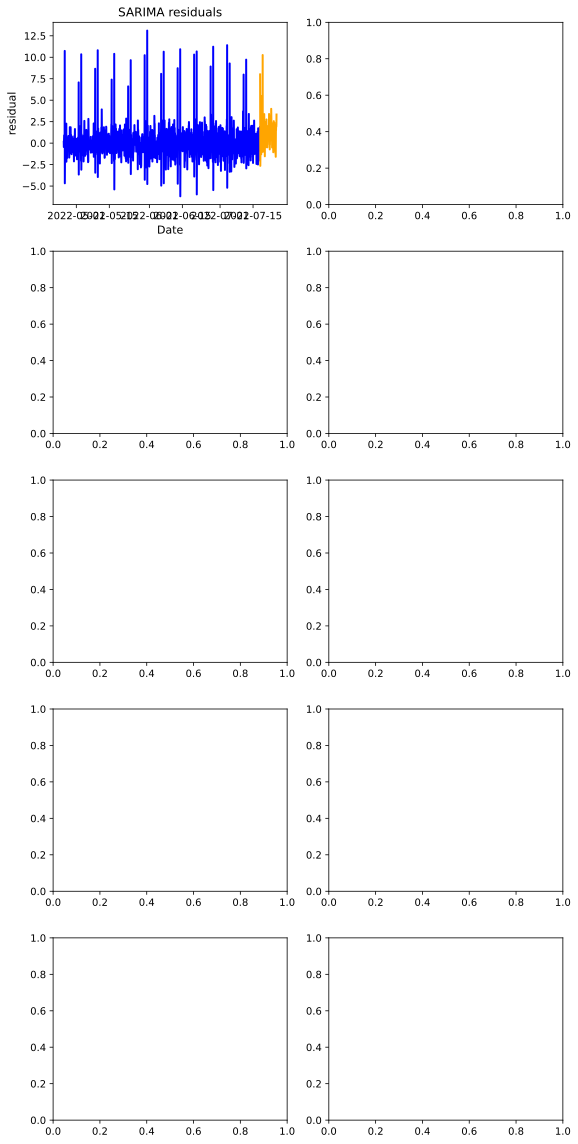

In [100]:
# plot residuals
fig, axs = plt.subplots(5, 2, figsize=(8, 16))
axs = axs.flatten()

for i, dma in enumerate(['dma_a']): 
    axs[i].plot(residuals_train[dma][-2000:], linewidth=2, color='blue', label='train')
    axs[i].plot(residuals_test[dma], linewidth=2, color='orange', label='test')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('residual')
    axs[i].set_title('SARIMA residuals')

fig.tight_layout()
plt.show()


KeyError: "Columns not found: 'dma_b_residual'"

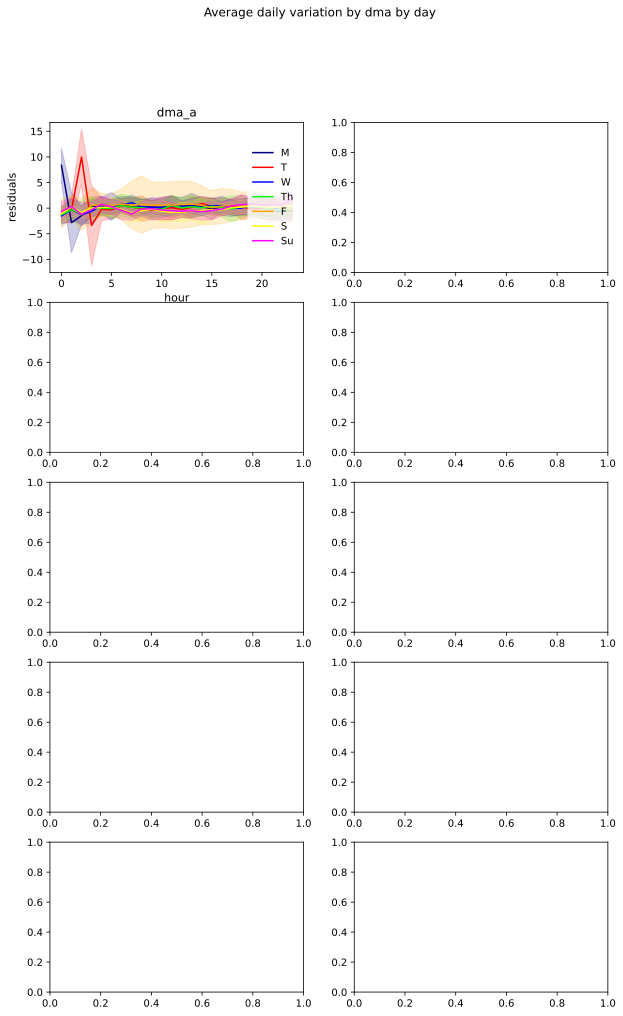

In [101]:
# plotting weekday averages of residuals
days = ['M', 'T', 'W', 'Th', 'F', 'S', 'Su']

colors = [
    "#FF0000",  # Red
    "#0000FF",  # Blue
    "#00FF00",  # Green
    "#FFA500",  # Orange
    "#FFFF00",  # Yellow
    "#FF00FF",  # Magenta
    "#00FFFF",  # Cyan
    "#800000",  # Maroon
    "#008000",  # Dark Green
    "#000080"   # Navy
]

fig, axs = plt.subplots(5, 2, figsize=(10, 16))
axs = axs.flatten()

fig.suptitle('Average daily variation by dma by day', fontsize=12)

for i, dma in enumerate(dmas):
    for day in np.arange(0,7): 
        mean = train_exog[train_exog['day']==day].groupby(by='hour')[[dma+'_residual']].mean()
        std = train_exog[train_exog['day']==day].groupby(by='hour')[[dma+'_residual']].std()
        lb = mean-1.96*std
        ub = mean+1.96*std
        axs[i].plot(mean, label=days[day], color=colors[day-1])
        axs[i].fill_between(lb.index, np.array(ub.T)[0], np.array(lb.T)[0], alpha=0.2, color=colors[day-1])
        
        axs[i].set_title(dma)
        axs[i].set_xlabel('hour')
        axs[i].set_ylabel('residuals')
        leg = axs[i].legend(loc='right', bbox_to_anchor=(1, 0.5),
            fancybox=False, shadow=False, ncol=1, edgecolor='w', borderpad=0.5)
        leg.get_frame().set_linewidth(0.5)

fig.tight_layout()
plt.show()


KeyError: 'dma_b_residual'

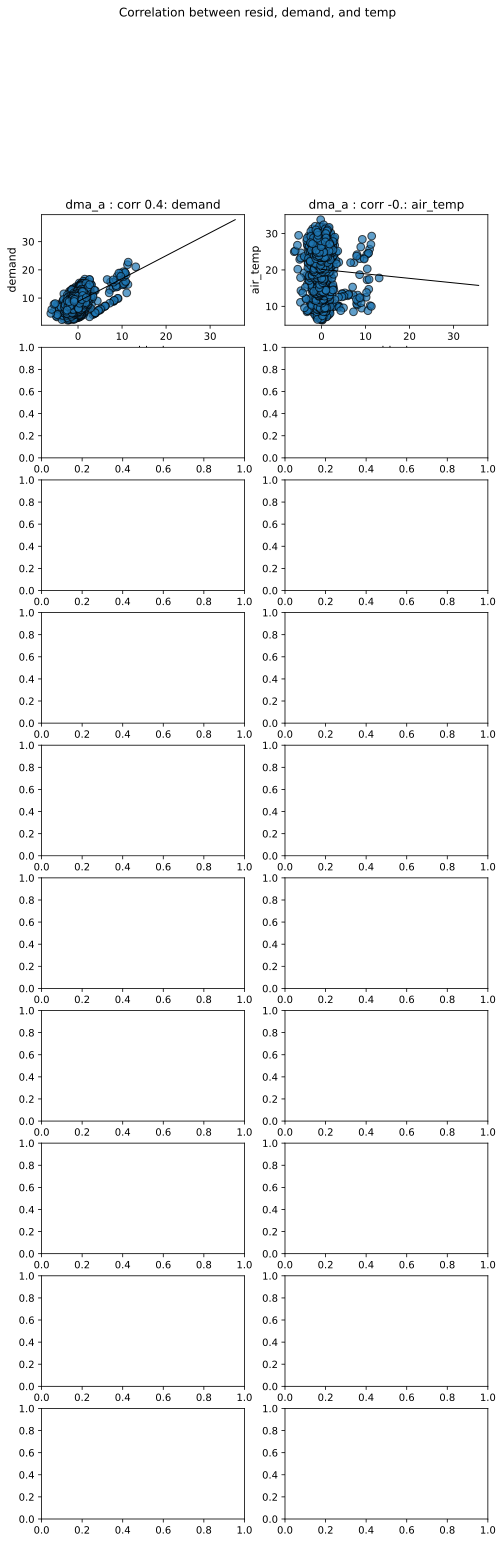

In [102]:
# plotting residual correlation to different exogeneous factors
import random

fig, axs = plt.subplots(10, 2, figsize=(8, 24))

factors = ['demand', 'air_temp']

fig.suptitle('Correlation between resid, demand, and temp', fontsize=12, y=1)

for i, dma in enumerate(dmas):
    for j, factor in enumerate(factors): 
        
        sample = pd.DataFrame()
        sample['x'] = train_exog[dma+'_residual']
        if factor == 'demand': 
            sample['y'] = train_exog[dma]
        else: 
            sample['y'] = train_exog[factor]
            
        sample = sample.dropna()
        
        # Plotting the histogram.
        axs[i][j].scatter(sample['x'], sample['y'], s=60, alpha=0.7, edgecolors="k")
        
        # get correlation
        corr = np.corrcoef(sample['x'], sample['y'])[0][1]

        # Fit linear regression via least squares with numpy.polyfit
        # It returns an slope (b) and intercept (a)
        # deg=1 means linear fit (i.e. polynomial of degree 1)
        b, a = np.polyfit(sample['x'], sample['y'], deg=1)
        
        xmin, xmax = 0, inflow_data[dma].max() * 1.2
        
        # Create sequence of 100 numbers from 0 to 100 
        xseq = np.linspace(xmin, xmax, num=100)

        # Plot regression line
        axs[i][j].plot(xseq, a + b * xseq, color="k", lw=1);
    
        axs[i][j].set_title(dma + ' : corr ' + repr(corr)[:3] + ': '+factor)
        axs[i][j].set_xlabel('residual')
        axs[i][j].set_ylabel(factor)

fig.tight_layout()
plt.show()

KeyError: 'dma_b_residual'

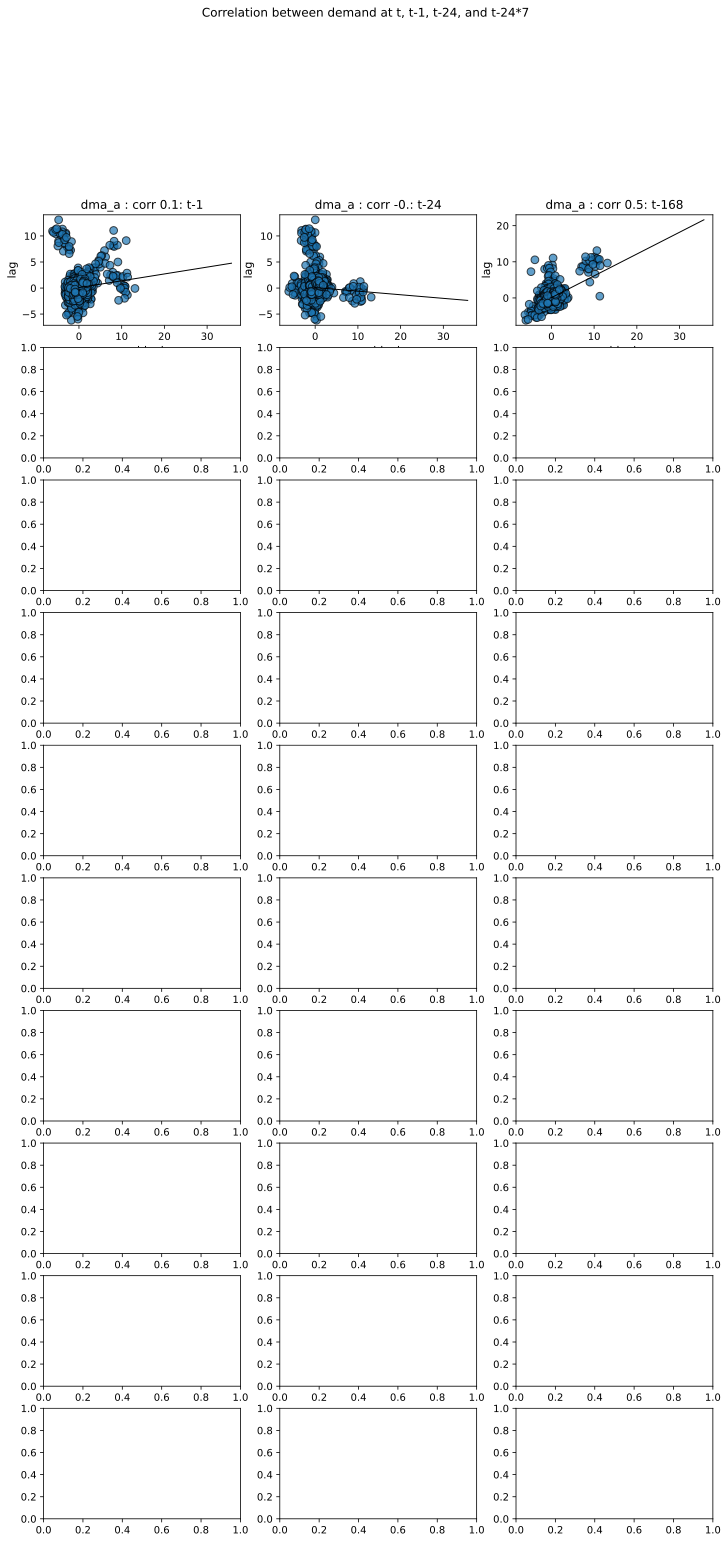

In [103]:
# plotting demand correlation to prior timesteps of importance
import random

fig, axs = plt.subplots(10, 3, figsize=(12, 24))

lags = [1, 24, 24*7]

fig.suptitle('Correlation between demand at t, t-1, t-24, and t-24*7 ', fontsize=12, y=1)

for i, dma in enumerate(dmas):
    for j, lag in enumerate(lags): 
        
        data = inflow_data.dropna()[0:3000]
        
        sample = pd.DataFrame()
        sample['x'] = train_exog[dma+'_residual']
        sample['y'] = train_exog.shift(lag)[dma+'_residual']
        sample = sample.dropna()
        
        # Plotting the histogram.
        axs[i][j].scatter(sample['x'], sample['y'], s=60, alpha=0.7, edgecolors="k")
        
        # get correlation
        corr = np.corrcoef(sample['x'], sample['y'])[0][1]

        # Fit linear regression via least squares with numpy.polyfit
        # It returns an slope (b) and intercept (a)
        # deg=1 means linear fit (i.e. polynomial of degree 1)
        b, a = np.polyfit(sample['x'], sample['y'], deg=1)
        
        xmin, xmax = 0, inflow_data[dma].max() * 1.2
        
        # Create sequence of 100 numbers from 0 to 100 
        xseq = np.linspace(xmin, xmax, num=100)

        # Plot regression line
        axs[i][j].plot(xseq, a + b * xseq, color="k", lw=1);
    
        axs[i][j].set_title(dma + ' : corr ' + repr(corr)[:3] + ': t-' + str(lag))
        axs[i][j].set_xlabel('residual')
        axs[i][j].set_ylabel('lag')

fig.tight_layout()
plt.show()

KeyError: 'dma_b_residual'

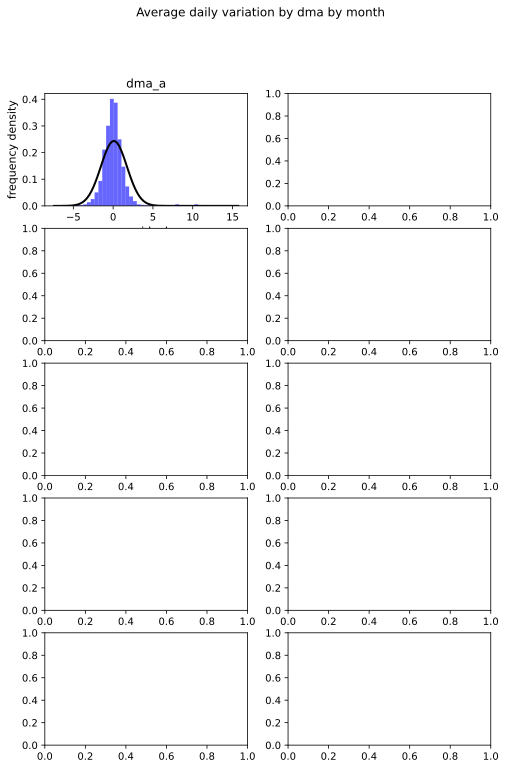

In [104]:
# plotting dma demand distributions vs normal
from scipy.stats import norm

fig, axs = plt.subplots(5, 2, figsize=(8, 12))
axs = axs.flatten()

fig.suptitle('Average daily variation by dma by month', fontsize=12)

for i, dma in enumerate(dmas):
    # Plotting the histogram.
    axs[i].hist(train_exog[dma+'_residual'], bins=40, density=True, alpha=0.6, color='b')
    
    # Fit a normal distribution to
    # the data:
    # mean and standard deviation
    mu, std = norm.fit(train_exog[dma+'_residual'].dropna(axis=0)) 
    
    # Plot the PDF
    xmin, xmax = train_exog[dma+'_residual'].min() * 1.2, train_exog[dma+'_residual'].max() * 1.2
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    axs[i].plot(x, p, 'k', linewidth=2)
    axs[i].set_title(dma)
    axs[i].set_xlabel('residual')
    axs[i].set_ylabel('frequency density')

fig.tight_layout()
plt.show()


KeyError: 'dma_b_residual'

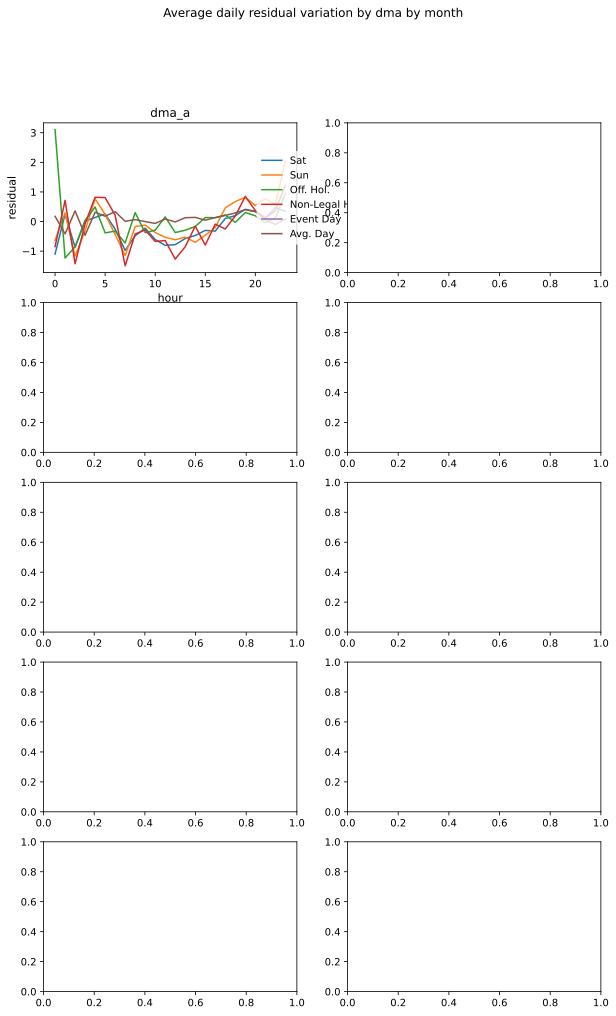

In [105]:
fig, axs = plt.subplots(5, 2, figsize=(10, 16))
axs = axs.flatten()

fig.suptitle('Average daily residual variation by dma by month', fontsize=12)

for i, dma in enumerate(dmas):
    axs[i].plot(train_exog[train_exog['day']==5].groupby(by='hour').mean()[dma+'_residual'], label='Sat')
    axs[i].plot(train_exog[train_exog['day']==6].groupby(by='hour').mean()[dma+'_residual'], label='Sun')
    axs[i].plot(train_exog[train_exog['official_holiday']==1].groupby(by='hour').mean()[dma+'_residual'], label='Off. Hol.')
    axs[i].plot(train_exog[train_exog['legally_not_recongnized_holidays']==1].groupby(by='hour').mean()[dma+'_residual'], label='Non-Legal Hol.')
    axs[i].plot(train_exog[train_exog['event_day']==1].groupby(by='hour').mean()[dma+'_residual'], label='Event Day')
    axs[i].plot(train_exog.groupby(by='hour').mean()[dma+'_residual'], label='Avg. Day')
    
    axs[i].set_title(dma)
    axs[i].set_xlabel('hour')
    axs[i].set_ylabel('residual')
    leg = axs[i].legend(loc='right', bbox_to_anchor=(1.3, 0.5),
        fancybox=False, shadow=False, ncol=1, edgecolor='w', borderpad=0.5)
    leg.get_frame().set_linewidth(0.5)

fig.tight_layout()
plt.show()

#### 7. SARIMAX (weather/imputing)

Running for dma_a...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.97620D+00    |proj g|=  1.69861D-01


 This problem is unconstrained.



At iterate    5    f=  1.85301D+00    |proj g|=  1.86603D-02

At iterate   10    f=  1.84044D+00    |proj g|=  4.30690D-03

At iterate   15    f=  1.83640D+00    |proj g|=  4.91928D-03

At iterate   20    f=  1.83252D+00    |proj g|=  9.28769D-03

At iterate   25    f=  1.83002D+00    |proj g|=  7.23535D-03

At iterate   30    f=  1.82966D+00    |proj g|=  6.98657D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     38      1     0     0   5.376D-06   1.830D+00
  F =   1.8296556046205634     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Running for dma_b...


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.08272D-01    |proj g|=  3.98254D-01

At iterate    5    f=  8.39088D-01    |proj g|=  1.08634D-01

At iterate   10    f=  8.27908D-01    |proj g|=  3.67836D-03

At iterate   15    f=  8.27894D-01    |proj g|=  7.24780D-04

At iterate   20    f=  8.27834D-01    |proj g|=  8.27586D-03

At iterate   25    f=  8.27666D-01    |proj g|=  2.83519D-03

At iterate   30    f=  8.27621D-01    |proj g|=  1.99585D-03

At iterate   35    f=  8.27615D-01    |proj g|=  1.16085D-04

At iterate   40    f=  8.27615D-01    |proj g|=  1.20416D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  6.94955D-01    |proj g|=  1.81628D-01

At iterate   10    f=  6.57841D-01    |proj g|=  3.39002D-02

At iterate   15    f=  6.55198D-01    |proj g|=  5.47569D-03

At iterate   20    f=  6.55193D-01    |proj g|=  3.05000D-05

At iterate   25    f=  6.55192D-01    |proj g|=  1.68854D-03

At iterate   30    f=  6.55187D-01    |proj g|=  7.41320D-04

At iterate   35    f=  6.55185D-01    |proj g|=  4.73462D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     50      1     0     0   5.826D-05   6.552D-01
  F =  0.65518531728921514     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43874D+00    |proj g|=  9.27170D-02

At iterate    5    f=  2.33753D+00    |proj g|=  2.29615D-02

At iterate   10    f=  2.33004D+00    |proj g|=  2.17808D-03

At iterate   15    f=  2.32989D+00    |proj g|=  2.30795D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     25      1     0     0   1.685D-06   2.330D+00
  F =   2.3298910273825286     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Running 

 This problem is unconstrained.



At iterate    5    f=  2.36463D+00    |proj g|=  3.45143D-02

At iterate   10    f=  2.36174D+00    |proj g|=  3.25902D-03

At iterate   15    f=  2.36168D+00    |proj g|=  1.37103D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     19      1     0     0   5.467D-06   2.362D+00
  F =   2.3616822017236920     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Running for dma_f...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58094D+00    |proj g|= 

 This problem is unconstrained.



At iterate    5    f=  1.48374D+00    |proj g|=  8.63665D-02

At iterate   10    f=  1.47830D+00    |proj g|=  4.35398D-03

At iterate   15    f=  1.47811D+00    |proj g|=  5.05204D-04

At iterate   20    f=  1.47800D+00    |proj g|=  1.09313D-02

At iterate   25    f=  1.47790D+00    |proj g|=  1.97846D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     34      1     0     0   2.962D-05   1.478D+00
  F =   1.4778958012747188     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Running for dma_g...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7

 This problem is unconstrained.



At iterate    5    f=  1.73126D+00    |proj g|=  1.19079D-02

At iterate   10    f=  1.72866D+00    |proj g|=  1.22425D-03

At iterate   15    f=  1.72857D+00    |proj g|=  1.49412D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   9.905D-06   1.729D+00
  F =   1.7285635930921814     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Running for dma_h...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.15719D+00    |proj g|= 

 This problem is unconstrained.



At iterate    5    f=  1.56047D+00    |proj g|=  6.72390D-02

At iterate   10    f=  1.52643D+00    |proj g|=  3.38286D-03

At iterate   15    f=  1.52637D+00    |proj g|=  7.11576D-04

At iterate   20    f=  1.52593D+00    |proj g|=  2.52285D-02

At iterate   25    f=  1.51914D+00    |proj g|=  2.17644D-02

At iterate   30    f=  1.51246D+00    |proj g|=  1.35370D-02

At iterate   35    f=  1.51192D+00    |proj g|=  8.04756D-04

At iterate   40    f=  1.51191D+00    |proj g|=  1.16847D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     48      1     0     0   1.168D-05   1.512D+00
  F =   1.51191023757

 This problem is unconstrained.



At iterate    5    f=  1.95690D+00    |proj g|=  3.96022D-02

At iterate   10    f=  1.95042D+00    |proj g|=  1.63712D-03

At iterate   15    f=  1.95017D+00    |proj g|=  7.56134D-03

At iterate   20    f=  1.94938D+00    |proj g|=  7.15682D-03

At iterate   25    f=  1.94932D+00    |proj g|=  1.49770D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     28      1     0     0   8.549D-07   1.949D+00
  F =   1.9493187984528624     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Running for dma_j...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7

 This problem is unconstrained.



At iterate    5    f=  3.51233D+00    |proj g|=  1.43512D+00

At iterate   10    f=  2.47494D+00    |proj g|=  6.60008D-02

At iterate   15    f=  2.33771D+00    |proj g|=  5.18269D-02

At iterate   20    f=  1.93356D+00    |proj g|=  2.39277D-01

At iterate   25    f=  1.77595D+00    |proj g|=  2.58175D-02

At iterate   30    f=  1.77487D+00    |proj g|=  1.91735D-03

At iterate   35    f=  1.77449D+00    |proj g|=  1.25231D-02

At iterate   40    f=  1.77425D+00    |proj g|=  2.51173D-03

At iterate   45    f=  1.77119D+00    |proj g|=  2.30359D-02

At iterate   50    f=  1.76913D+00    |proj g|=  1.11597D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

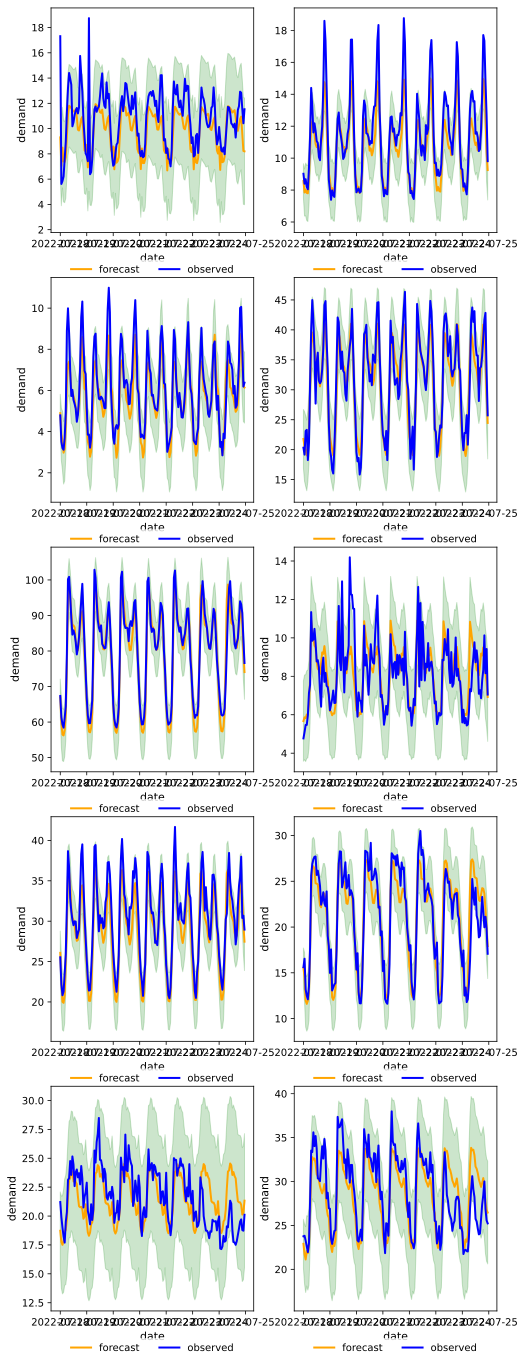

In [106]:
# imports
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# make empty datafram to store results
results_c = test.copy()
ci_lower = test.copy()
ci_upper = test.copy()
residuals_train = pd.DataFrame()
residuals_test = pd.DataFrame()

# setup plot
# comparison of initial data and transform
fig, axs = plt.subplots(5, 2, figsize=(8,24))
axs = axs.flatten()

# select dma for analysis
for i, dma in enumerate(dmas):
    print(f"Running for {dma}...")
    
    y_train = train[dma].copy()
    y_test = test[dma].copy()
    
    x_train = train_exog['air_temp'].copy()
    x_test = test_exog['air_temp'].copy()
    
    # implement sarimaX model    
    # the statsmodel package applies the difference already if needed.
    model = SARIMAX(y_train, exog=x_train, order=(2,0,2), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
    model_fit = model.fit()
    y_pred = model_fit.get_forecast(len(y_test), exog=x_test).summary_frame(alpha=0.05)

    results_c[dma] = y_pred['mean']
    ci_lower[dma] = y_pred['mean_ci_lower']
    ci_upper[dma] = y_pred['mean_ci_upper']
    residuals_train[dma] = model_fit.resid
    residuals_test[dma] = test[dma] - y_pred['mean']

    # plot results
    axs[i].plot(results_c[dma], color='orange', label='forecast', linewidth=2)
    axs[i].plot(y_test, color='blue', label='observed', linewidth=2)
    axs[i].fill_between(results_c.index, ci_lower[dma], ci_upper[dma] ,color='green',alpha=0.2)

    axs[i].set_ylabel('demand')
    axs[i].set_xlabel('date')
    leg = axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
        fancybox=False, shadow=False, ncol=6, edgecolor='w', borderpad=0.5)
    leg.get_frame().set_linewidth(0.5)
    
    

plt.show()

In [96]:
# print metrics
mape = {dma: metrics.mape(results_c[dma], test[dma]) for dma in dmas}
mape['total'] = sum(mape.values())
rmse = {dma: metrics.rmse(results_c[dma], test[dma]) for dma in dmas}
rmse['total'] = sum(rmse.values())
mae = {dma: metrics.mae(results_c[dma], test[dma]) for dma in dmas}
mae['total'] = sum(mae.values())

print(mape)


{'dma_a': 0.12045043329999595, 'dma_b': 0.0, 'dma_c': 0.0, 'dma_d': 0.0, 'dma_e': 0.0, 'dma_f': 0.0, 'dma_g': 0.0, 'dma_h': 0.0, 'dma_i': 0.0, 'dma_j': 0.0, 'total': 0.12045043329999595}


NameError: name 'dma_dfs' is not defined

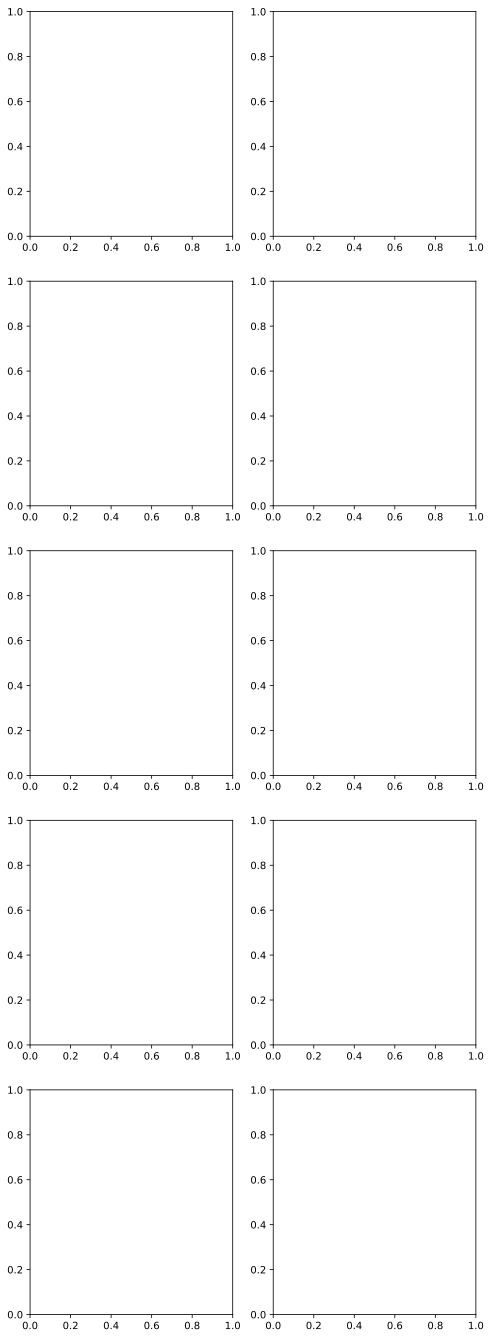

In [94]:
training_window = 24

# comparison of prediction and actual
fig, axs = plt.subplots(5, 2, figsize=(8,24))
axs = axs.flatten()
    
for i,dma in enumerate(dmas): 
    train_ts = train[dma]
    test_ts = dma_dfs[dma]

    history = [x for x in train_ts]
    history = history[(-training_window):]

    predictions = list()

    # run autoreg model for each dma
    for t in range(test_ts.shape[0]):
        model = AutoReg(history, 1)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=3)
        predictions.append(yhat[0])
        obs = list(test_ts.iloc[t])
        history.append(obs[0])
        history.pop(0)
        
    axs[i].plot(train_ts[-training_window:], 'blue', linewidth=2, label='Observations')    
    axs[i].plot(test_ts.index, test_ts, 'blue', linewidth=2, label='Observations')
    axs[i].plot(test_ts.index, predictions, 'orange', linewidth=2, label='Predicted')
    axs[i].set_ylabel('demand')
    axs[i].set_xlabel("hours")
        
    leg = axs[i].legend(loc='right', bbox_to_anchor=(1.2, 0.5),
        fancybox=False, shadow=False, ncol=1, edgecolor='w', borderpad=0)
    leg.get_frame().set_linewidth(0.5)
    

### Modelling Residuals

#### 1. Univariate GRU

In [ ]:
# NN parameters required in data prep
T = 6
HORIZON = 1

